<h1>Segmenting and Clustering Neighborhoods in Toronto</h1>

Peer-graded assigment for Coursera's "_Applied Data Science Capstone_" course, the last in the _IBM Data Science Professional Certificate_ specialization

<h2>Question 1: Getting the list of Neighborhoods</h2>

<b>OBJECTIVE:</b> Create a dataframe with all postcodes from Toronto along with its respective boroughs and neighborhoods.<br>
<b>METHOD:</b> Web scrapping of a Wikipedia page.<br>
<b>RESULTS:</b>

The following function uses Beautiful Soup to scrape tables from a given URL and returns a dataframe with the data:

In [1]:
def scrape_table( url , table_number=0 ):
    request = requests.get(url)
    html_doc = request.text
    soup = BeautifulSoup( html_doc , 'html.parser')
    table = soup.find_all('table')[table_number]
    
    rows =[]
    column_names = []

    for row in table.find_all('tr'):
        th_tags = row.find_all('th')
        for th in th_tags:
            column_names.append( th.get_text().strip() )
        
        td_tags = row.find_all('td')
        if( len(td_tags)>0 ):
            tmp_row = []
            for td in td_tags: 
                tmp_row.append( td.get_text().strip() )

            rows.append( tmp_row )

    df = pd.DataFrame.from_records(rows)
    df.columns = column_names

    return df

First we use the function above to scrape the Wikipedia page.

In [2]:
import requests
from   bs4      import BeautifulSoup
import pandas   as     pd

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

df_neighborhoods = scrape_table(url,0)
shape1 = df_neighborhoods.shape
print('We scrapped a table with {} rows and {} columns.\n'.format(shape1[0],shape1[1]))
df_neighborhoods.head()

We scrapped a table with 289 rows and 3 columns.



,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


We will work with this dataframe to clean it and format it according to the assignment's requirements.

In [3]:
# Removing entries for which Borough is 'Not assigned'
df_neighborhoods = df_neighborhoods.drop( df_neighborhoods[(df_neighborhoods['Borough']=='Not assigned') ].index , axis=0 ).reset_index().drop('index',axis=1)

shape2 = df_neighborhoods.shape
print('{} entries were removed because they didn\'t have useful information.'.format(shape1[0]-shape2[0]))
print('The dataframe has how {} rows. Each corresponds to a neighborhood.\n'.format(shape2[0]))

df_neighborhoods.head()

77 entries were removed because they didn't have useful information.
The dataframe has how 212 rows. Each corresponds to a neighborhood.



,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [4]:
# Making unassigned neighborhoods the same as its respective boroughs
for index in df_neighborhoods[ df_neighborhoods['Neighbourhood']=="Not assigned" ].index:
    df_neighborhoods.iloc[index,2]=df_neighborhoods.iloc[index,1]

In [5]:
# Now we need to create a table in which each Postcode appears just once.
# Multiple neighbourhoods must be merged in a single row
# The final dataframe should have 1 row for each unique postcode

postcode_list = df_neighborhoods['Postcode'].unique()

num_unique_postcodes = len(postcode_list)
print('We have {} unique postcodes.\n'.format(num_unique_postcodes))

We have 103 unique postcodes.



In [6]:
borough_list       = []
neighbourhood_list = []

for postcode in postcode_list:
    
    borough_list.append( df_neighborhoods[df_neighborhoods['Postcode']==postcode]['Borough'].unique()[0] )
    
    tmp_list=[]
    for neighbourhood in df_neighborhoods[ df_neighborhoods['Postcode']==postcode ]['Neighbourhood']:
        tmp_list.append(neighbourhood)
    neighbourhood_list.append(', '.join( tmp_list ))

df_neighborhoods_combined = pd.DataFrame.from_records( zip(postcode_list,borough_list,neighbourhood_list) )
df_neighborhoods_combined.columns = ['Postcode','Borough','Neighbourhoods']

df_neighborhoods_combined.head(12)

,Postcode,Borough,Neighbourhoods
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [7]:
df_neighborhoods_combined.shape

(103, 3)

<hr>

<h2>Question 2: Getting the coordinates for each postcode</h2>

<b>OBJECTIVE:</b> Get the coordinates (latitude and longitude) of each of Toronto's neighborhoods.<br>
<b>METHOD:</b> Geocoding APIs.<br>
<b>RESULTS:</b>
It is not possible to use the Google Map API for free anymore and the provided alternative failed to return coordinates.<br>
I looked for other alternatives but I didn't find a service than can recognize all neighborhoods.<br>

Therefore, I'm using the file provided by the instructor.

In [8]:
df_postcodes = pd.read_csv('Geospatial_Coordinates.csv')
df_postcodes.columns = ['Postcode','Latitude','Longitude']
df_postcodes.head(12)

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [9]:
df_postcodes.shape

(103, 3)

Making a single dataframe if all information we have at the moment.

In [10]:
df_geoinfo = pd.merge( df_neighborhoods_combined , df_postcodes, on=['Postcode'], how='inner')
df_geoinfo.head(12)

,Postcode,Borough,Neighbourhoods,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


In [11]:
df_geoinfo.shape

(103, 5)

<hr>

<h2>Question 3: Explore and cluster the neighborhoods in Toronto</h2>

<b>OBJECTIVE:</b> Explore and cluster the neighborhoods in Toronto<br> 
<b>METHODS:</b> <i>i</i>) A "venue profile" will be constructed for each venue consisting of the relative frequency of the venues categories that were suggested by the Foursquare API. <i>ii</i>) Clustering will be performed with the k-means algorithm.
<b>RESULTS:</b>

How are the 103 neighborhoods/postcodes distributed around Toronto?

In [12]:
# Functions for making maps with Folium

def map_define( center_lat , center_lng ):
    map_rp_fig = folium.Figure(width=512,height=512)
    map_rp = folium.Map( location=[center_lat,center_lng], zoom_start=10, tiles="OpenStreetMap")
    map_rp.add_to(map_rp_fig)
    
    return map_rp


def map_markers( folium_map , lat_list , lng_list , label_list , color , radius ):
    for lat,lng,label in zip(lat_list,lng_list,label_list):
        folium.features.CircleMarker(location=[lat,lng],
                                     popup=str(label.replace('\'','_').replace('\\','_').replace('/','_').replace(':','_')),
                                     color=color,
                                     fill=True,
                                     fill_color=color,
                                     fill_opacity=0.75,
                                     radius=radius).add_to(folium_map)
    return folium_map

In [13]:
import folium

lat_toronto =  43.729839
lon_toronto = -79.372769 

map_postcodes = map_define( lat_toronto , lon_toronto )
map_postcodes = map_markers( map_postcodes , df_geoinfo['Latitude'] , df_geoinfo['Longitude'], df_geoinfo['Postcode'] , 'red' , 4 )
map_postcodes

Now let's use the Foursquare API to get the popular venues around each postcode.

In [14]:
# Function to get the coordinates of each neighborhood/postcodes 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=1000
    CLIENT_ID='X23432AINNXT522Z1335TOP1UBCVX0HDXHQWVASBXVTC3MLI'
    CLIENT_SECRET='FMSBJCIT4JJSRHVO5L2NF52SSB5TFM1JSK0EISS0ACBDWL5C'
    VERSION=20190121
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
df_venues = getNearbyVenues( names=df_geoinfo['Postcode'], latitudes=df_geoinfo['Latitude'], longitudes=df_geoinfo['Longitude'] )

df_venues.to_csv('venues_raw.csv') # Saving the coordinates in a csv file to avoid too many queries during development

In [15]:
# This was made to avoid using too many queries to the Foursquare API during development

df_venues = pd.read_csv('venues_raw.csv', index_col=0)

In [16]:
print(df_venues.shape)
df_venues.head()

(2244, 5)


,Postcode,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,KFC,43.754387,-79.333021,Fast Food Restaurant
2,M3A,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M3A,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
4,M4A,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


Let's make a single dataframe with all information again

In [17]:
df_all = pd.merge( df_venues , df_geoinfo , on='Postcode', how='inner')
df_all.tail()

,Postcode,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,Neighbourhoods,Latitude,Longitude
2239,M8Z,Subway,43.631518,-79.518856,Sandwich Place,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999
2240,M8Z,McDonald's,43.630078,-79.517901,Fast Food Restaurant,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999
2241,M8Z,Jim & Maria's No Frills,43.632004,-79.518918,Grocery Store,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999
2242,M8Z,Islington Florist & Nursery,43.630156,-79.518718,Flower Shop,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999
2243,M8Z,Kingsway Boxing Club,43.627254,-79.526684,Gym,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999


In [18]:
df_all.shape

(2244, 9)

Since some reference coordinates for the neighborhoods are close to each other, there may be duplicate venues. Let's check that

In [19]:
# New dataframe to check for duplicate entries
df_venues_unique = df_all.copy()
df_venues_unique.drop(['Postcode','Neighbourhoods','Borough','Latitude','Longitude'] , axis=1 , inplace=True)
shape1 = df_venues_unique.shape

df_venues_unique.drop_duplicates(inplace=True)
shape2 = df_venues_unique.shape

num_venues = shape1[0]
num_duplicate_venues = shape1[0]-shape2[0]

print('There are {} venues. {} of them are repeated and {} are unique in our dataframe.'.format(num_venues,num_duplicate_venues,shape2[0]))

There are 2244 venues. 484 of them are repeated and 1760 are unique in our dataframe.


How are the venues distributed around Toronto?
Let's plot them in the map to find out. We'll use only yhe unique ones to save computational power

In [20]:
map_venues = map_define( lat_toronto , lon_toronto )
map_venues = map_markers( map_venues , df_venues_unique['Venue Latitude'] , df_venues_unique['Venue Longitude'] , df_venues_unique['Venue Category'] , 'blue' , 4 )
map_venues = map_markers( map_venues , df_geoinfo['Latitude'] , df_geoinfo['Longitude'], df_geoinfo['Postcode'] , 'red' , 2 )
map_venues

Are there neighborhoods for which no venues were found?

In [21]:
list_postcodes_all         = df_postcodes['Postcode']
list_postcodes_with_venues = df_venues['Postcode'].unique()


list_postcodes_without_venues = [ i for i in list_postcodes_all if i not in list_postcodes_with_venues ]

num_postcodes_without_venues = len(list_postcodes_without_venues)

print('There are {} postcodes for which no venues were found.\nThey are {}'.format(num_postcodes_without_venues,list_postcodes_without_venues))

There are 2 postcodes for which no venues were found.
They are ['M1X', 'M9A']


Let's explore the venue data a little bit.
Which are the top 10 most common venues in Toronto?

In [22]:
num_unique_venues=len(df_venues_unique['Venue'].unique())
print('We have %s unique venue names. The most common are:' % num_unique_venues)
top10 = pd.DataFrame(df_venues_unique['Venue'].value_counts().head(10))

top10.index.name = 'Venue'
top10.columns = ['Count']


#top10['Category'] = 
tmp_list=[]
for venue in top10.index.values:
    tmp_list.append( df_venues_unique[ df_venues_unique['Venue']==venue]['Venue Category'].unique()[0] )
top10['Category'] = tmp_list

top10
#top10
#df_dupl2['Venue Latitude']
#df_dupl2['Venue Longitude']

We have 1445 unique venue names. The most common are:


,Count,Category
Venue,,
Starbucks,46,Coffee Shop
Tim Hortons,35,Coffee Shop
Subway,27,Sandwich Place
Shoppers Drug Mart,19,Pharmacy
TD Canada Trust,16,Bank
LCBO,14,Liquor Store
Pizza Pizza,12,Pizza Place
Dollarama,10,Discount Store
The Beer Store,9,Beer Store


There are at least 46 Starbuck shops in Toronto!
The second most common venue, Tim Hortons, is also a coffe shop.

What about the most common categories?

In [23]:
num_unique_categories=len(df_venues_unique['Venue Category'].unique())
print('We have %s unique categories. The most common are:' % num_unique_categories)
pd.DataFrame(df_venues_unique['Venue Category'].value_counts().head(10))

We have 279 unique categories. The most common are:


,Venue Category
Coffee Shop,139
Café,76
Pizza Place,50
Restaurant,49
Park,48
Bakery,40
Italian Restaurant,39
Bar,37
Sandwich Place,36
Fast Food Restaurant,36


This is in agreement with the most common venues we observed.<br>


Let's transform our data to perform the clustering!

For that, we will apply the one-hot encode approach to the 'Venue Category' column.

In [24]:
df_onehot = pd.get_dummies( df_venues['Venue Category'] )
df_onehot['Postcode'] = df_venues['Postcode']

columns_fixed_order = [ df_onehot.columns[-1] ] + list( df_onehot.columns[:-1] )
df_onehot = df_onehot[columns_fixed_order]

df_onehot.set_index('Postcode',inplace=True)

df_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Postcode,,,,,,,,,,,,,,,,,,,,,
M3A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M3A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M3A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M3A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M4A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will know use the one-hot encoding to calculate the frequency of each category in each postcode.

We now have a dataframe with one row for each venue.<br>
First we will group the data by Postcode and them sum their one-hot variables, which will serve as counters for each category of venue for each neighborhood/postcode.

In [25]:
df_onehot.shape

(2244, 279)

In [26]:
df_venue_count = df_onehot.groupby('Postcode').sum(axis=1)
df_venue_count.shape

(101, 279)

We had thousands of rows before, each one representing a venue.<br>
Now we have one row for each postcode/neighborhood. (Venues for which the Foursquare API didn't return venues are absent here.)

Now we count the total number of venues per postcode.

In [27]:
df_venue_count['Venues per postcode'] = df_venue_count.sum(axis=1)
df_venue_count.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Venues per postcode
Postcode,,,,,,,,,,,,,,,,,,,,,
M1B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
M1C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
M1E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
M1G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
M1H,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


We can use this data to find, e.g., which are the postcodes/neighborhoods for which we have the most number of venues.

In [28]:
df_venue_count.sort_values(by='Venues per postcode',ascending=False)['Venues per postcode'].head(10)

Postcode
M5K    100
M5J    100
M5B    100
M5X    100
M5T    100
M5C    100
M5L    100
M5H    100
M5W     95
M4Y     87
Name: Venues per postcode, dtype: int64

How about the neighborhoods with the least number of venues?

In [29]:
df_venue_count.sort_values(by='Venues per postcode',ascending=True)['Venues per postcode'].head(10)

Postcode
M1B    1
M4T    1
M9L    1
M5N    1
M9B    1
M8Y    1
M2M    1
M2P    2
M1V    2
M2L    2
Name: Venues per postcode, dtype: int64

We can see that our venue count ranges from 1 to 100 (which is the Foursquare API limit).

Finally, we divide each column by the total of venues per postcode. This will yield the frequency of each venue category for each postcode.

In [30]:
df_venue_frequency = df_venue_count.copy()

for column in df_venue_frequency.columns:
    df_venue_frequency[column] = ((df_venue_frequency[column]/df_venue_frequency['Venues per postcode'])*100)

df_venue_frequency.drop('Venues per postcode',axis=1,inplace=True)
df_venue_frequency.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Postcode,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_venue_frequency.shape

(101, 279)

Which categories are the most common for one of the neighborhoods/postcodes with the biggest number of venues, e.g., M5K ?

In [32]:
df_venue_frequency.loc['M5K',].sort_values(ascending=False).head(10)

Coffee Shop            14.0
Hotel                   8.0
Café                    8.0
Restaurant              4.0
American Restaurant     4.0
Gastropub               3.0
Italian Restaurant      3.0
Deli / Bodega           3.0
Gym                     3.0
Bar                     2.0
Name: M5K, dtype: float64

What about one of the neighborhoods/postcodes with the smallest number of venues, e.g., M1B ?

In [33]:
df_venue_frequency.loc['M1B',].sort_values(ascending=False).head(10)

Fast Food Restaurant           100.0
Dumpling Restaurant              0.0
Diner                            0.0
Discount Store                   0.0
Dog Run                          0.0
Doner Restaurant                 0.0
Donut Shop                       0.0
Drugstore                        0.0
Eastern European Restaurant      0.0
Field                            0.0
Name: M1B, dtype: float64

Now we have a dataframe in which we have the percentage of each venue category for each postcode.<br>
In this representation, the postcodes will have different 'venue profiles' as described by the different percentages encoded in the columns. This will be captured by the clustering algorithm.

Finally, let's proceed to the clsutering.<br>
We will use the k-Means algorithm.

First we will try to estimate the best value for k.

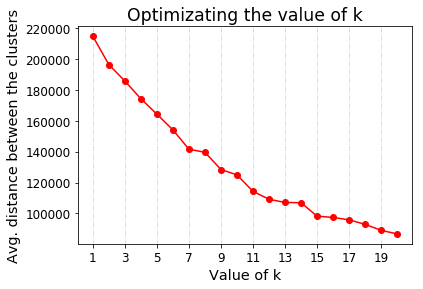

In [35]:
from   sklearn.cluster   import KMeans
import matplotlib.pyplot as     plt

# set number of clusters
total_ks=20

ks=[]
score=[]

for k in range(1,total_ks+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_venue_frequency)
    score.append(kmeans.inertia_)
    ks.append(k)



plt.plot(ks,score,'o-r')

plt.xticks(ticks=range(1,total_ks+1,2),fontsize='large')
plt.xlabel('Value of k',fontsize='x-large')

plt.yticks(fontsize='large')
plt.ylabel('Avg. distance between the clusters',fontsize='x-large')

plt.grid(which='major', alpha=0.5, axis='x', linestyle='-.')

plt.title('Optimizating the value of k',fontsize='xx-large')

plt.show()

It is not very clear, but it looks like k=7 is an elbow point. k=2 also looks interesting.<br>
Therefore, we will build our clustering model with k=7.

In [36]:
# set number of clusters
k = 7

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_venue_frequency)

# check cluster labels generated for each row in the dataframe
kmeans.labels_.shape

(101,)

Including the cluster id in a dataframe

In [37]:
df_clust = pd.DataFrame(df_venue_frequency.index.values)
df_clust.columns = ['Postcode']

df_clust['Cluster'] = kmeans.labels_

display(df_clust.head(5))
print(df_clust.shape)

,Postcode,Cluster
0,M1B,2
1,M1C,2
2,M1E,2
3,M1G,2
4,M1H,2


(101, 2)


Now let's get the coordinates of the neighborhoods/postcodes.

In [38]:
df_clust = pd.merge( df_clust , df_geoinfo, on='Postcode', how='inner')

display(df_clust.head(5))
print(df_clust.shape)

,Postcode,Cluster,Borough,Neighbourhoods,Latitude,Longitude
0,M1B,2,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,2,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,2,Scarborough,Woburn,43.770992,-79.216917
4,M1H,2,Scarborough,Cedarbrae,43.773136,-79.239476


(101, 6)


Let's visualize how the clusters are organized around Toronto.

In [40]:
import numpy             as np
import matplotlib.cm     as cm
import matplotlib.colors as colors

map_clusters = map_define( lat_toronto , lon_toronto )

colors_array = cm.rainbow(np.linspace(0, 1, k))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for cl in range(0,k):
    tmp = df_clust[ df_clust['Cluster']==cl ]
    map_clusters = map_markers( map_clusters , tmp['Latitude'] , tmp['Longitude'] , tmp['Postcode'], rainbow[cl] , 3 )

map_clusters

One cluster is much bigger than the other. Let's investigate this further.

In [41]:
df_clust_sizes = pd.DataFrame(df_clust['Cluster'].value_counts())
df_clust_sizes.index.name = 'Cluster ID'
df_clust_sizes.columns = ['Count']
df_clust_sizes['Percentage'] = np.round((df_clust_sizes['Count']/df_clust_sizes['Count'].sum())*100 , 1)

display(df_clust_sizes)


,Count,Percentage
Cluster ID,,
2,79,78.2
0,13,12.9
6,3,3.0
5,2,2.0
4,2,2.0
3,1,1.0
1,1,1.0


Indeed, cluster 2 has 79% of all venues.<br>
The biggest problem, however, is that most clusters are very small, with as little as just 1 venue in the cluster. This may be happening because we requested too many clusters to the k-Means algorithm and it had to create "artificial" clusters.<br> Let's try reducing the number of clusters.

The next possible elbow point identified during our optimization for values of k was 2. So let's repeat the clustering with k=2.

In [42]:
# Clustering again with k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_venue_frequency)

# Building the dataframe with the clustering results
df_clust = pd.DataFrame(df_venue_frequency.index.values)
df_clust.columns = ['Postcode']
df_clust['Cluster'] = kmeans.labels_
df_clust = pd.merge( df_clust , df_geoinfo, on='Postcode', how='inner')

Visualizing the new clusters

In [43]:
map_clusters = map_define( lat_toronto , lon_toronto )

colors_array = cm.rainbow(np.linspace(0, 1, k))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for cl in range(0,k):
    tmp = df_clust[ df_clust['Cluster']==cl ]
    map_clusters = map_markers( map_clusters , tmp['Latitude'] , tmp['Longitude'] , tmp['Postcode'], rainbow[cl] , 3 )

map_clusters

The "artificial clusters" are gone now, great!<br>
In numbers:

In [44]:
df_clust_sizes = pd.DataFrame(df_clust['Cluster'].value_counts())
df_clust_sizes.index.name = 'Cluster ID'
df_clust_sizes.columns = ['Count']
df_clust_sizes['Percentage'] = np.round((df_clust_sizes['Count']/df_clust_sizes['Count'].sum())*100 , 1)

display(df_clust_sizes)

,Count,Percentage
Cluster ID,,
1,86,85.1
0,15,14.9


The distribution between the two clusters are similar to what was observed before for the two most populated clusters, which reinforces our hypothesis that most clusters were artificially created because we requested too many clusters out of our data.

How are these clusters different? Let's investigate the most common venue categories for each of them.

In [45]:
def normalize_column(df,column):
    return df[column]/df[column].sum()

for cluster in range(0,k):

    postcodes_cluster = df_clust[df_clust['Cluster']==cluster]['Postcode'].unique()
    
    cluster_size = len( df_clust[df_clust['Cluster']==cluster]['Postcode'] )
    cluster_size_perc = np.round( (cluster_size / df_clust['Cluster'].count())*100 , 1 )
    
    print('Profile of cluster with ID={}:'.format(cluster))
    print('  It has {} members ({}% of total venues)'.format( cluster_size,cluster_size_perc))
    
    tmp  = pd.DataFrame()
    tmp2 = pd.DataFrame()

    for postcode in postcodes_cluster:
        tmp[postcode]=df_venue_frequency.loc[postcode,]
    tmp2 = pd.DataFrame(tmp.transpose().mean().sort_values(ascending=False).head(5))
    tmp2.reset_index(inplace=True)
    tmp2.columns=['Venue Category','Venue Mean Frequency']
    tmp2['Venue Frequency in top-5'] = np.round(normalize_column(tmp2,'Venue Mean Frequency')*100,1)
    display(tmp2)

Profile of cluster with ID=0:
  It has 15 members (14.9% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,Park,36.666667,68.8
1,Playground,5.000000,9.4
2,Convenience Store,4.444444,8.3
3,Bus Stop,3.888889,7.3
4,Bus Line,3.333333,6.3


Profile of cluster with ID=1:
  It has 86 members (85.1% of total venues)


,Venue Category,Venue Mean Frequency,Venue Frequency in top-5
0,Coffee Shop,6.537886,33.7
1,Pizza Place,3.583422,18.5
2,Café,3.422423,17.7
3,Fast Food Restaurant,3.104559,16.0
4,Sandwich Place,2.735891,14.1


We can see that the bigger cluster, ID=1, is dominated by coffee shops, which account for more than 50% of its members (33.7% for the category "Coffee Shop" + 17.7% for the category "Café"). It also has restaurants.

The smaller cluster, ID=0, is dominated mostly by parks, which account for 68.8% of its venues. It also has playgrounds, convenience stores and bus stops/lines.

<b>CONCLUSIONS:</b><br>
It was possible to segment the neighborhoods of Toronto in two distinct clusters. The biggest cluster, which accounts for 85% of the neighborhoods, have an assortment of coffee shops and restaurants. It represents densely urbanized areas.

The smaller cluster, which accounts for 15% of the neighborhoods, is characterized by parks, playgrounds and access by bus. It gathers neighborhoods rich in green space.

We observed that even when trying to segment our data in more clusters, we obtained two bigger and several tiny clusters. We hypothesize that these tiny cluster are were artificially created by the k-Means algorithm because we requested more clusters that our data can actually be segmented into.<br>
It is possible to refine our results following by:
- increasing the amount of data, i.e., getting information about more venues for each neighborhood from the Fourspace API;
- curating the data about the venues, specifically by merging some categories into broader ones. We saw, for example, the categories "Coffee Shop" and "Café" as well as several types of restaurants. It may the useful to merge such categories into broader ones because they are interpreted as different features by the clustering algorithm when they actually are small variations of the same venue type. This is possibly acting as noise in our model.


Our results can be applied to decide where to buy a new house. If one prefers a urban lifestyle, neighborhoods that belong to the bigger cluster should be preferred. On the other hand, if one prefers a lifestyle which is closer to nature, neighborhoods that belong to the smaller cluster should be preferred. 
Regions which are in the interface between the two clusters are also interesting because it offers good access to both the natural and urban-focused lifestyles.

<hr>
<b>Leandro Oliveira Bortot, PhD</b><br>
<i>Prospective Data Scientist</i><br>
Ribeirão Preto, São Paulo<br>
Brazil<br>